In [1]:
import pennylane as qml
import pennylane.numpy as np

from scipy.stats import mode
from scipy.stats import wasserstein_distance

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from scipy.integrate import quad

In [2]:
torch_pi = torch.Tensor([np.pi])

In [3]:
### Test function
def Complex_Phase_function(x):
    return np.cos(x + 0.5*np.sin(4*x))

In [4]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, 
                               create_graph=True, 
                               grad_outputs=torch.ones(y.size()))[0]

def integrate_numerical(func, start, end):
    integral, _ = quad(func, start, end)
    return integral

In [5]:
def R2_estimation(pred, num):
    N = len(num)
    sigma = np.var(num)
    r2 = 1 - (1 / (N * sigma)) * np.sum(((pred - num) ** 2))
    return r2

def Mean_Relative_Error(I_pred, I_num):
    mre = np.mean(np.abs((I_num - I_pred) / (I_num + 1e-8)))
    return mre

In [6]:
### Pennylane Quantum Device ####################################
dev_QNN = qml.device("default.qubit", wires = 2)
dev_QNN_noise = qml.device("default.mixed", wires = 2)
dev_QSP = qml.device("default.qubit", wires = 4)
dev_QSP_noise = qml.device("default.mixed", wires = 4)
dev_DQC1 = qml.device('default.qubit', wires = 3)
dev_DQC1_noise = qml.device("default.mixed", wires = 3)

@qml.qnode(dev_QNN, interface='torch')
def QNN_circuit(layers, x, theta):
    i = 0

    for _ in range(layers):
        for q in range(2):
            qml.RY(theta[i], wires = q)
            qml.RZ(theta[i+1] * x, wires = q)
            qml.RX(theta[i+2], wires = q)
            i += 3
        
        qml.CZ(wires = [0, 1])

    qml.RY(theta[-1], wires = 0)
    qml.RY(theta[-2], wires = 1)

    return qml.expval((qml.PauliZ(0)+qml.PauliZ(1))/2)

### Quantum Circuit - BitFlip ####################################
@qml.qnode(dev_QNN_noise, interface='torch')
def QNN_circuit_BitFlip(layers, x, phi):
    i = 0

    for _ in range(layers):
        for q in range(2):
            qml.RY(phi[i], wires = q)
            qml.RZ(phi[i+1] * x, wires = q)
            qml.RX(phi[i+2], wires = q)
            i += 3
        
        qml.CZ(wires = [0, 1])

    qml.RY(phi[-1], wires = 0)
    qml.RY(phi[-2], wires = 1)

    qml.BitFlip(0.001, wires = 0)
    qml.BitFlip(0.001, wires = 1)

    return qml.expval((qml.PauliZ(0)+qml.PauliZ(1))/2)


### Quantum Circuit - Depoloarizing ####################################
@qml.qnode(dev_QNN_noise, interface='torch')
def QNN_circuit_Depolarizing(layers, x, phi):
    i = 0

    for _ in range(layers):
        for q in range(2):
            qml.RY(phi[i], wires = q)
            qml.RZ(phi[i+1] * x, wires = q)
            qml.RX(phi[i+2], wires = q)
            i += 3
        
        qml.CZ(wires = [0, 1])

    qml.RY(phi[-1], wires = 0)
    qml.RY(phi[-2], wires = 1)

    qml.DepolarizingChannel(0.001, wires = 0)
    qml.DepolarizingChannel(0.001, wires = 1)

    return qml.expval((qml.PauliZ(0)+qml.PauliZ(1))/2)

################################################################################################################################################
### QSP Circuit ####################################
@qml.qnode(dev_QSP, interface = 'torch')
def QSP_circuit(layers, x, phi):
    theta = -2 * torch.arccos(x)
    
    qml.Hadamard(wires = 0)
    qml.Hadamard(wires = 1)
    for i in range(layers):
        qml.CRZ(phi[i], wires=[0,1])
        qml.CRX(theta, wires=[0,1], id = "SRO")
    qml.CRZ(phi[layers], wires=[0,1])  
    qml.Hadamard(wires = 1)
    qml.Hadamard(wires = 0)

    qml.Hadamard(wires = 2)
    qml.Hadamard(wires = 3)
    for i in range(layers-1):
        qml.CRZ(phi[layers+1+i], wires=[2,3])
        qml.CRX(theta, wires=[2,3], id = "SRO")
    qml.CRZ(phi[-1], wires=[2,3])  
    qml.Hadamard(wires = 3)
    qml.Hadamard(wires = 2)

    return qml.expval((qml.PauliZ(0)+qml.PauliZ(2))/2)

### QSP Circuit - BitFlip ####################################
@qml.qnode(dev_QSP_noise, interface = 'torch')
def QSP_circuit_BitFlip(layers, x, phi):
    theta = -2 * torch.arccos(x)
    
    qml.Hadamard(wires = 0)
    qml.Hadamard(wires = 1)
    for i in range(layers):
        qml.CRZ(phi[i], wires=[0,1])
        qml.CRX(theta, wires=[0,1], id = "SRO")
    qml.CRZ(phi[layers], wires=[0,1])  
    qml.Hadamard(wires = 1)
    qml.Hadamard(wires = 0)

    qml.Hadamard(wires = 2)
    qml.Hadamard(wires = 3)
    for i in range(layers-1):
        qml.CRZ(phi[layers+1+i], wires=[2,3])
        qml.CRX(theta, wires=[2,3], id = "SRO")
    qml.CRZ(phi[-1], wires=[2,3])  
    qml.Hadamard(wires = 3)
    qml.Hadamard(wires = 2)

    qml.BitFlip(0.001, wires = 0)
    qml.BitFlip(0.001, wires = 2)

    return qml.expval((qml.PauliZ(0)+qml.PauliZ(2))/2)

### QSP Circuit - Depolarizing ####################################
@qml.qnode(dev_QSP_noise, interface = 'torch')
def QSP_circuit_Depolarizing(layers, x, phi):
    theta = -2 * torch.arccos(x)
    
    qml.Hadamard(wires = 0)
    qml.Hadamard(wires = 1)
    for i in range(layers):
        qml.CRZ(phi[i], wires=[0,1])
        qml.CRX(theta, wires=[0,1], id = "SRO")
    qml.CRZ(phi[layers], wires=[0,1])  
    qml.Hadamard(wires = 1)
    qml.Hadamard(wires = 0)

    qml.Hadamard(wires = 2)
    qml.Hadamard(wires = 3)
    for i in range(layers-1):
        qml.CRZ(phi[layers+1+i], wires=[2,3])
        qml.CRX(theta, wires=[2,3], id = "SRO")
    qml.CRZ(phi[-1], wires=[2,3])  
    qml.Hadamard(wires = 3)
    qml.Hadamard(wires = 2)

    qml.DepolarizingChannel(0.001, wires = 0)
    qml.DepolarizingChannel(0.001, wires = 2)

    return qml.expval((qml.PauliZ(0)+qml.PauliZ(2))/2)

################################################################################################################################################
def S(x, theta, wires):
    qml.RX(theta[0]*x, wires = wires[0])
    qml.RX(theta[1]*x, wires = wires[1])

def W(phi, wires):
    i = 0
    for w in wires:
        qml.RX(phi[i], wires = w) 
        qml.RY(phi[i+1], wires = w)
        qml.RZ(phi[i+2], wires = w) 
        i += 3
    
    qml.CZ(wires = wires)

def DQC1_Unit(layers, x, thetas, phis, wires):
    i = 0

    for _ in range(layers):
        W(phis[i], wires)
        S(x, thetas[i], wires)
        i += 1
    W(phis[i], wires)

### DQC1 Circuit ####################################
@qml.qnode(dev_DQC1, interface = 'torch')
def DQC1_circuit(layers, x, thetas, phis):
    qml.Hadamard(0)

    qml.ctrl(DQC1_Unit, 0)(layers, x, thetas, phis, [1,2])

    return qml.expval(qml.PauliX(wires = 0))


### DQC1 Circuit - Bit Flip ####################################
@qml.qnode(dev_DQC1_noise, interface = 'torch')
def DQC1_circuit_BitFlip(layers, x, thetas, phis):
    qml.Hadamard(0)

    qml.ctrl(DQC1_Unit, 0)(layers, x, thetas, phis, [1,2])

    qml.BitFlip(0.001, wires = 0)

    return qml.expval(qml.PauliX(wires = 0))

### DQC1 Circuit - Depolarizing ####################################
@qml.qnode(dev_DQC1_noise, interface = 'torch')
def DQC1_circuit_Depolarizing(layers, x, thetas, phis):
    qml.Hadamard(0)

    qml.ctrl(DQC1_Unit, 0)(layers, x, thetas, phis, [1,2])

    qml.DepolarizingChannel(0.001, wires = 0)

    return qml.expval(qml.PauliX(wires = 0))

################################################################################################################################################
### VQC 모델(QNN - Ideal) ####################################
class QNN_Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(6 * layers + 2, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_paramters = 6 * layers + 2
        self.num_qubits = 2
        self.num_layers = layers

    def forward(self, data_point):
        output = QNN_circuit(self.num_layers, data_point, self.theta)
        return output
    
### VQC 모델(QNN - Gate Error) ####################################
class QNN_Model_GateError(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(6 * layers + 2, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_paramters = 6 * layers + 2
        self.num_qubits = 2
        self.num_layers = layers

    def forward(self, data_point):
        noise = torch.randn(len(self.theta))
        noise_theta = self.theta + 0.001 * noise
        output = QNN_circuit(self.num_layers, data_point, noise_theta)
        return output

### VQC 모델(QNN - BitFlip) ####################################
class QNN_Model_BitFlip(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(6 * layers + 2, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_paramters = 6 * layers + 2
        self.num_qubits = 2
        self.num_layers = layers

    def forward(self, data_point):
        outputs = torch.zeros_like(data_point)
        for i, x in enumerate(data_point):
            outputs[i] = QNN_circuit_BitFlip(self.num_layers, x, self.theta)
        return outputs
    

### VQC 모델(QNN - Depolarizing) ####################################
class QNN_Model_Depolarizing(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(6 * layers + 2, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_paramters = 6 * layers + 2
        self.num_qubits = 2
        self.num_layers = layers

    def forward(self, data_point):
        outputs = torch.zeros_like(data_point)
        for i, x in enumerate(data_point):
            outputs[i] = QNN_circuit_Depolarizing(self.num_layers, x, self.theta)
        return outputs

################################################################################################################################################
### VQC 모델(QSP - Ideal)  ####################################
class QSP_Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(2 * layers + 1, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_phi = 2 * layers + 1
        self.num_qubits = 4
        self.num_layers = layers

    def forward(self, data_point):
        """PennyLane forward implementation"""
        output = QSP_circuit(self.num_layers, data_point, self.theta)
        return output
    
### VQC 모델(QSP - Gate Error)  ####################################
class QSP_Model_GateError(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(2 * layers + 1, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_parameters = 2 * layers + 1
        self.num_qubits = 4
        self.num_layers = layers

    def forward(self, data_point):
        noise = torch.randn(len(self.theta))
        noise_theta = self.theta + 0.001 * noise
        output = QSP_circuit(self.num_layers, data_point, noise_theta)
        return output
    
### VQC 모델(QSP - BitFlip)  ####################################
class QSP_Model_BitFlip(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(2 * layers + 1, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_parameters = 2 * layers + 1
        self.num_qubits = 4
        self.num_layers = layers

    def forward(self, data_point):
        outputs = torch.zeros_like(data_point)
        for i, x in enumerate(data_point):
            outputs[i] = QSP_circuit_BitFlip(self.num_layers, x, self.theta)
        return outputs
    
### VQC 모델(QSP - Depolarizing)  ####################################
class QSP_Model_Depolarizing(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.theta = torch_pi * torch.rand(2 * layers + 1, requires_grad=True)
        self.theta = nn.Parameter(self.theta)
    
        self.num_training_parameters = 2 * layers + 1
        self.num_qubits = 4
        self.num_layers = layers

    def forward(self, data_point):
        outputs = torch.zeros_like(data_point)
        for i, x in enumerate(data_point):
            outputs[i] = QSP_circuit_Depolarizing(self.num_layers, x, self.theta)
        return outputs
    
############################################################################################################
### VQC 모델(DQC1 - Ideal)  ####################################
class DQC1_Model(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.phi = torch.rand((degree+1, 6), requires_grad=True)
        self.theta = torch.rand((degree, 2) ,requires_grad = True)
        self.phi = nn.Parameter(self.phi)
        self.theta = nn.Parameter(self.theta)
    
        self.num_phi = 6 * degree + 6 + 2 * degree
        self.num_qubits = 2
        self.num_layers = degree

    def forward(self, data_point):
        output = DQC1_circuit(self.num_layers, data_point, self.theta, self.phi)
        return output
    
### VQC 모델(DQC1 - Gate Error)  ####################################
class DQC1_Model_GateError(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.phi = torch.rand((degree+1, 6), requires_grad=True)
        self.theta = torch.rand((degree, 2) ,requires_grad = True)
        self.phi = nn.Parameter(self.phi)
        self.theta = nn.Parameter(self.theta)
    
        self.num_phi = 6 * degree + 6 + 2 * degree
        self.num_qubits = 2
        self.num_layers = degree

    def forward(self, data_point):
        noise1 =torch.randn_like(self.phi)
        noise2 = torch.randn_like(self.theta)
        noise_phi = self.phi + 0.001 * noise1
        noise_theta = self.theta + 0.001 * noise2
        output = DQC1_circuit(self.num_layers, data_point, noise_theta, noise_phi)
        return output
    
### VQC 모델(DQC1 - Bit Flip) ####################################
class DQC1_Model_BitFlip(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.phi = torch.rand((degree+1, 6), requires_grad=True)
        self.theta = torch.rand((degree, 2) ,requires_grad = True)
        self.phi = nn.Parameter(self.phi)
        self.theta = nn.Parameter(self.theta)
    
        self.num_phi = 6 * degree + 6 + 2 * degree
        self.num_qubits = 2
        self.num_layers = degree

    def forward(self, data_point):
        outputs = torch.zeros_like(data_point)
        for i, x in enumerate(data_point):
            outputs[i] = DQC1_circuit_BitFlip(self.num_layers, x, self.theta, self.phi)
        return outputs
    
### VQC 모델(DQC1 - Depolarizing) ####################################
class DQC1_Model_Depolarizing(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.phi = torch.rand((degree+1, 6), requires_grad=True)
        self.theta = torch.rand((degree, 2) ,requires_grad = True)
        self.phi = nn.Parameter(self.phi)
        self.theta = nn.Parameter(self.theta)
    
        self.num_phi = 6 * degree + 6 + 2 * degree
        self.num_qubits = 2
        self.num_layers = degree

    def forward(self, data_point):
        outputs = torch.zeros_like(data_point)
        for i, x in enumerate(data_point):
            outputs[i] = DQC1_circuit_Depolarizing(self.num_layers, x, self.theta, self.phi)
        return outputs

In [7]:
def load_model_environment(model, env, layers):
    model_classes = {
        "QNN": {
            "Ideal": QNN_Model,
            "GateError": QNN_Model_GateError,
            "BitFlip": QNN_Model_BitFlip,
            "Depolarizing": QNN_Model_Depolarizing,
        },
        "QSP": {
            "Ideal": QSP_Model,
            "GateError": QSP_Model_GateError,
            "BitFlip": QSP_Model_BitFlip,
            "Depolarizing": QSP_Model_Depolarizing,
        },
        "DQC1": {
            "Ideal": DQC1_Model,
            "GateError": DQC1_Model_GateError,
            "BitFlip": DQC1_Model_BitFlip,
            "Depolarizing": DQC1_Model_Depolarizing,
        }
    }

    try:
        model_class = model_classes[model][env]
        return model_class(layers)
    except KeyError:
        raise ValueError(f"Invalid model ({model}) or environment ({env}) specified.")


----

In [8]:
model_type = 'QNN'  # QNN / QSP / DQC1
test_func = 'CPF'    # CPF / Step / BW
sample_type = 'Uni' # Uni / Imp / HMC
loss_type = 'MSE'   # MSE / Chisqr / Log_Cosh / MSE_KL
env = 'Ideal'       # Ideal / GateErorr / BitFlip / Noise
lr = 0.005          # 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005
layers = 10

path = f"Results/{model_type}/{env}/{test_func}/{sample_type}/{loss_type}/{lr}"
print(path)

Results/QNN/Ideal/CPF/Uni/MSE/0.005


In [9]:
QNN_model = load_model_environment(model_type, env, layers)
QNN_model.load_state_dict(torch.load(f'./{path}/QNN_Ideal_L10_1000_1_465_e03.pt'))
QNN_model.eval()

def Integration_with_QNN(start, end):
    init = QNN_model(start)
    final = QNN_model(end)
    return final - init

### Test Function :Complex Phase Fucntion
----

In [10]:
samples = 100
lower = -2 * np.pi
upper = 2 * np.pi
s_scale = (upper - lower) / 2
s_bias = (upper + lower) / (upper - lower)
s_mid = (upper + lower) / 2

slin = np.linspace(lower, upper, samples)
flin = Complex_Phase_function(slin)
f_scale = np.max(flin)
xlin = slin / s_scale - s_bias
ylin = flin / f_scale

xlin = torch.tensor(xlin, requires_grad=True)
Qx = QNN_model(xlin)
dQdx = derivative(Qx, xlin)

Text(50.097222222222214, 0.5, 'rel. error')

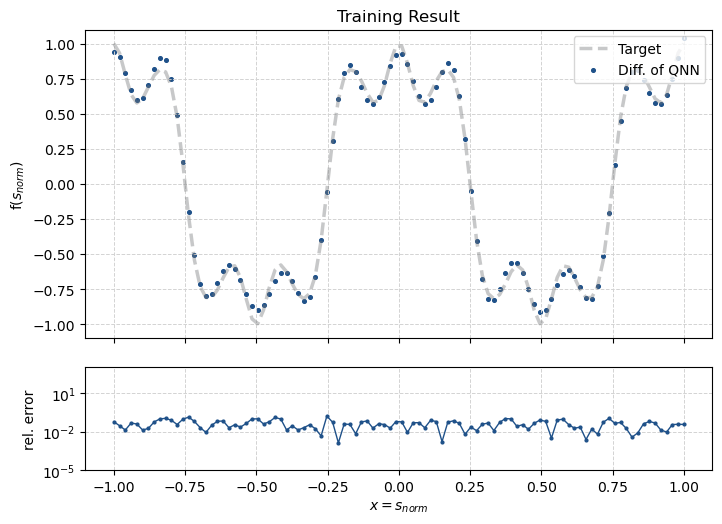

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.0, 5.0), 
                               gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.15)
plt.tight_layout()

ax1.plot(xlin.detach().numpy(), ylin, color="#747678", linestyle="--", linewidth=2.5, alpha = .4, label="Target")
ax1.scatter(xlin.detach().numpy(), dQdx.detach().numpy(),  color = '#1f5189', s = 7, label="Diff. of QNN")

ax1.set_ylim(-1.1, 1.1)
ax1.grid(True, color="lightgray", linestyle="--", linewidth=0.7)
ax1.set_ylabel("f($s_{norm}$)")
ax1.set_title(f"Training Result")
ax1.legend(loc="upper right", fancybox=True, framealpha = 0.8)

rel_error = np.abs((dQdx.detach().numpy() - ylin) / np.abs(ylin)) 

ax2.plot(xlin.detach().numpy(), rel_error, color = '#1f5189', linestyle="-", linewidth=1, marker='o', markersize=2)

ax2.set_yscale('log')
ax2.set_ylim(1e-5, 1e3)
ax2.grid(color="lightgray", linestyle="--", linewidth=0.7)
ax2.set_xlabel("$x = s_{norm}$")
ax2.set_ylabel("rel. error")

In [12]:
r2 = R2_estimation(dQdx.detach().numpy()[1:-1], ylin[1:-1])
print(r2)

0.9972544919404207


----
### Integral

In [13]:
subintervals = 30
step = (upper - lower) / subintervals
s_init = np.linspace(lower, upper - step, subintervals, endpoint=True)
s_end = np.linspace(lower + step, upper, subintervals, endpoint=True)
x_init = (s_init - s_mid) / s_scale
x_end = (s_end - (s_mid)) / s_scale

x_init = torch.tensor(x_init)
x_end = torch.tensor(x_end)

int_pred = f_scale * s_scale * np.array([Integration_with_QNN(x_init[i], x_end[i]).detach().numpy() for i in range(len(s_init))])
int_num = np.array([integrate_numerical(Complex_Phase_function, s_init[i], s_end[i]) for i in range(len(s_end))])

Text(50.097222222222214, 0.5, 'rel. error')

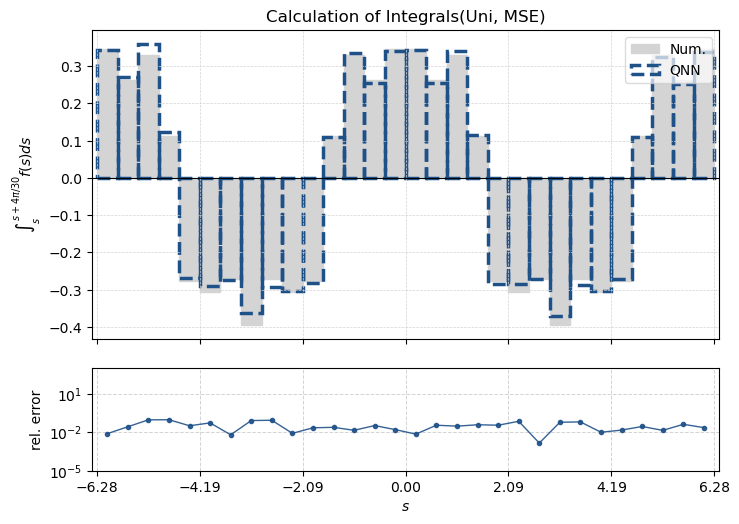

In [14]:
major_ticks = np.arange(lower, upper+step, 5*step)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.0, 5.0), 
                               gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.15)
plt.tight_layout()

ax1.bar(s_init, int_num, align = 'edge', width = step, facecolor = "#d4d4d5", edgecolor ="#d4d4d5", fill = True, label = "Num.")
ax1.bar(s_init, int_pred, align = 'edge',  width = step, edgecolor ="#1f5189", fill = False, linestyle = '--', lw = 2.5, label = "QNN")

ax1.set_xticks(major_ticks)
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_xlim(lower - 0.1, upper + 0.1) 
ax1.grid(color="lightgray", linestyle="--", linewidth=0.5)
ax1.set_ylabel("$\int_s^{s+4\pi / 30} f(s)ds$", )
ax1.set_title(f"Calculation of Integrals({sample_type}, {loss_type})")
ax1.legend(loc="upper right", framealpha = 0.7)

rel_error = np.abs((int_num-int_pred) / int_num)

ax2.plot(s_init+step/2, rel_error, color="#1f5189", linestyle="-", linewidth=1, marker='o', markersize=3, alpha=0.9)

ax2.set_yscale('log')
ax2.set_ylim(1e-5, 1e3)
ax2.grid(color="lightgray", linestyle="--", linewidth=0.7)
ax2.set_xlabel("$s$")
ax2.set_ylabel("rel. error")

In [15]:
mre = Mean_Relative_Error(int_pred, int_num)
print(mre)

0.034802911747858725


In [16]:
J_true = np.cumsum(int_num)
J_pred = np.cumsum(int_pred)
J_true_norm = J_true / (np.max(J_true))
J_pred_norm = J_pred / (np.max(J_pred))

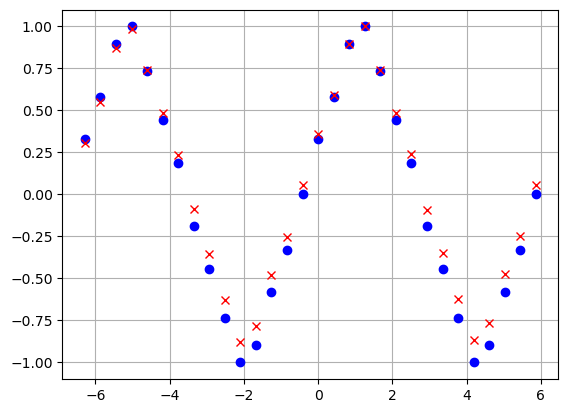

In [17]:
plt.plot(s_init, J_true_norm, 'bo')
plt.plot(s_init, J_pred_norm, 'rx')
plt.grid()

In [18]:
wd = wasserstein_distance(J_true_norm, J_pred_norm)
wd

0.06355058414917017

In [19]:
stp

NameError: name 'stp' is not defined

In [ ]:
print(path)

In [ ]:
np.savez(f"./{path}/Model_Prediction.npz", xlin = xlin.detach().numpy(), target = ylin, dQdx = dQdx.detach().numpy(), slin = s_init, prediction = int_pred, integral = int_num, cum_idx = s_init, cum_true = J_true_norm, cum_pred = J_pred_norm)
np.savez(f"./{path}/Model_Estimation.npz", diff_R2 = r2, int_mre = mre, int_Wd = wd)

In [ ]:
stp

In [20]:
s_init = 0
s_end = np.pi / 2
x_init = (s_init - s_mid) / s_scale
x_end = (s_end - (s_mid)) / s_scale

x_init = torch.tensor(x_init)
x_end = torch.tensor(x_end)

int_num = np.array([integrate_numerical(Complex_Phase_function, s_init, s_end)])
int_preds = []
for _ in range(100):
    int_pred = f_scale * s_scale * np.array([Integration_with_QNN(x_init, x_end).detach().numpy()])
    int_preds.append(int_pred)

print("Numeric(Scipy Quad):", int_num)
print("QNN Model :", np.mean(int_preds), np.std(int_preds), mode(int_preds))
print("Relative Error :", np.abs(int_num - int_pred) / int_num * 100)

Numeric(Scipy Quad): [1.06713792]
QNN Model : 1.069535208635059 2.220446049250313e-16 ModeResult(mode=array([1.06953521]), count=array([100.]))
Relative Error : [0.22464677]


In [21]:
s_init = - np.pi / 2
s_end = np.pi / 2
x_init = (s_init - s_mid) / s_scale
x_end = (s_end - (s_mid)) / s_scale

x_init = torch.tensor(x_init)
x_end = torch.tensor(x_end)

int_num = np.array([integrate_numerical(Complex_Phase_function, s_init, s_end)])

int_preds = []
for _ in range(100):
    int_pred = f_scale * s_scale * np.array([Integration_with_QNN(x_init, x_end).detach().numpy()])
    int_preds.append(int_pred)

print("Numeric(Scipy Quad):", int_num)
print("QNN Model :", np.mean(int_preds), np.std(int_preds), mode(int_preds))
print("Relative Error :", np.abs(int_num - int_pred) / int_num * 100)

Numeric(Scipy Quad): [2.13427584]
QNN Model : 2.1251058872320745 4.440892098500626e-16 ModeResult(mode=array([2.12510589]), count=array([100.]))
Relative Error : [0.42965151]


In [22]:
s_init = - np.pi
s_end = np.pi 
x_init = (s_init - s_mid) / s_scale
x_end = (s_end - (s_mid)) / s_scale

x_init = torch.tensor(x_init)
x_end = torch.tensor(x_end)

int_num = np.array([integrate_numerical(Complex_Phase_function, s_init, s_end)])

int_preds = []
for _ in range(100):
    int_pred = f_scale * s_scale * np.array([Integration_with_QNN(x_init, x_end).detach().numpy()])
    int_preds.append(int_pred)

print("Numeric(Scipy Quad):", int_num)
print("QNN Model :", np.mean(int_preds), np.std(int_preds), mode(int_preds))
print("Relative Error :", np.abs(int_num - int_pred) / (int_num) * 100)

Numeric(Scipy Quad): [1.29280909e-16]
QNN Model : 0.000951486908556886 2.168404344971009e-19 ModeResult(mode=array([0.00095149]), count=array([100.]))
Relative Error : [7.35984081e+14]
